In [ ]:
from huggingface_hub import notebook_login
from transformers import AutoImageProcessor, AutoModelForImageClassification
from datasets import load_dataset
import torch
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import subprocess
import os

In [3]:
from google.colab import userdata
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

# Load Model and Data

In [ ]:
processor = AutoImageProcessor.from_pretrained("nateraw/food")
model = AutoModelForImageClassification.from_pretrained("nateraw/food")

ds = load_dataset("food101", split="validation", trust_remote_code=True)

In [5]:
ds = ds.shuffle(seed=99)
dataset_sample = ds[:500]

# Test on single example

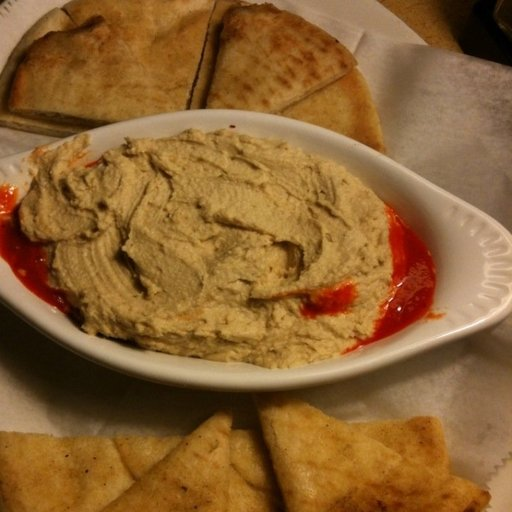

In [6]:
image = dataset_sample["image"][7]
image

In [7]:
predicted_label = dataset_sample["label"][7]
model.config.id2label[predicted_label]

'hummus'

In [8]:
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

hummus


# Evaluate Performance on the whole sample

In [ ]:
true_labels = []
predicted_labels_og = []

for image, label in zip(dataset_sample["image"], dataset_sample["label"]):

    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_label = logits.argmax(-1).item()

    true_labels.append(label)
    predicted_labels_og.append(predicted_label)

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels_og)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(true_labels, predicted_labels_og)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 88.00%
Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]


# Evaluate Performance on the upscaled images

## Test on single image

In [9]:
image = dataset_sample["image"][7]
image_array = np.array(image)

# Transform image to .bmp format
img = Image.fromarray(image_array)
img.save("image.bmp", format="BMP")

# Run upscaling model on the image
subprocess.run(['python', 'test.py', '--weights-file', 'epoch_2_best.pth', '--image-file', 'image.bmp', '--scale', '3'])

# Convert the loaded upscaled image to JpegImageFile format
image = Image.open("image_srcnn_x3.bmp")
image = image.convert("RGB")

# Run the classification model on the new upscaled image
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

hummus


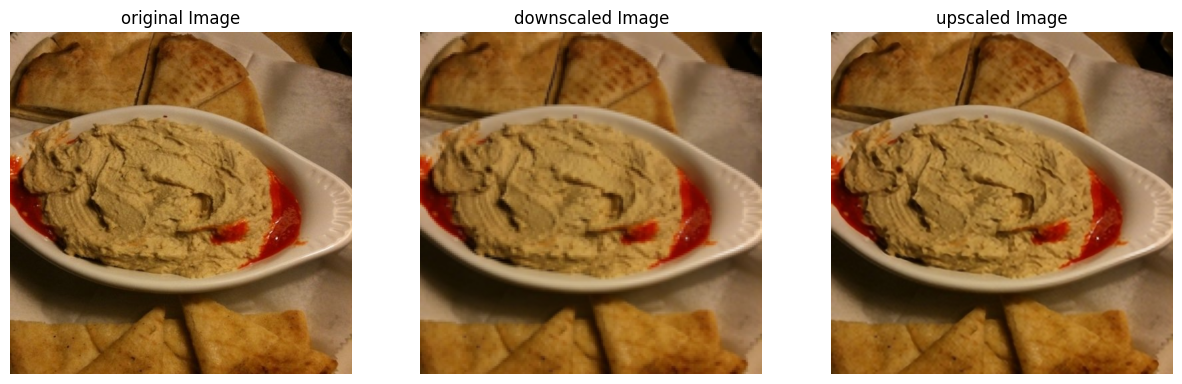

In [13]:
import matplotlib.pyplot as plt

# Get files for plotting
original = Image.open("image.bmp").convert("RGB")
downscaled = Image.open("image_bicubic_x3.bmp").convert("RGB")
upscaled = Image.open("image_srcnn_x3.bmp").convert("RGB")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original)
axes[0].set_title("original Image")

axes[1].imshow(downscaled)
axes[1].set_title("downscaled Image")

axes[2].imshow(upscaled)
axes[2].set_title("upscaled Image")

for ax in axes:
    ax.axis("off")

plt.show()

In [10]:
def compare_images(index):
    image = dataset_sample["image"][index]
    image_array = np.array(image)
    # Transform image to .bmp format
    img = Image.fromarray(image_array)
    img.save("image.bmp", format="BMP")

    # Run upscaling model on the image
    subprocess.run(['python', 'test.py', '--weights-file', 'epoch_4(BEST).pth', '--image-file', 'image.bmp', '--scale', '3'])

    # Get files for plotting
    original = Image.open("image.bmp").convert("RGB")
    downscaled = Image.open("image_bicubic_x3.bmp").convert("RGB")
    upscaled = Image.open("image_srcnn_x3.bmp").convert("RGB")

    print(f"True label of image below is { model.config.id2label[ dataset_sample['label'][index] ] }")
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title(f"original Image - {model.config.id2label[predicted_labels_og[index]]}")

    axes[1].imshow(downscaled)
    axes[1].set_title("downscaled Image")

    axes[2].imshow(upscaled)
    axes[2].set_title(f"upscaled Image - {model.config.id2label[predicted_labels_up_new[index]]}")

    for ax in axes:
        ax.axis("off")

    plt.show()

## Run the classification task on the upscaled images

In [ ]:
true_labels = []
predicted_labels_up = []

for image, label in zip(dataset_sample["image"], dataset_sample["label"]):
    image_array = np.array(image)

    # Transform image to .bmp format
    img = Image.fromarray(image_array)
    img.save("image.bmp", format="BMP")

    # Run upscaling model on the image
    subprocess.run(['python', 'test.py', '--weights-file', 'best.pth', '--image-file', 'image.bmp', '--scale', '3'])

    # Convert the loaded upscaled image to JpegImageFile format
    image = Image.open("image_srcnn_x3.bmp")
    image = image.convert("RGB")

    # Run the classification model on the new upscaled image
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_label = logits.argmax(-1).item()

    true_labels.append(label)
    predicted_labels_up.append(predicted_label)

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels_up)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(true_labels, predicted_labels_up)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 87.60%
Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]


True label of image below is gyoza


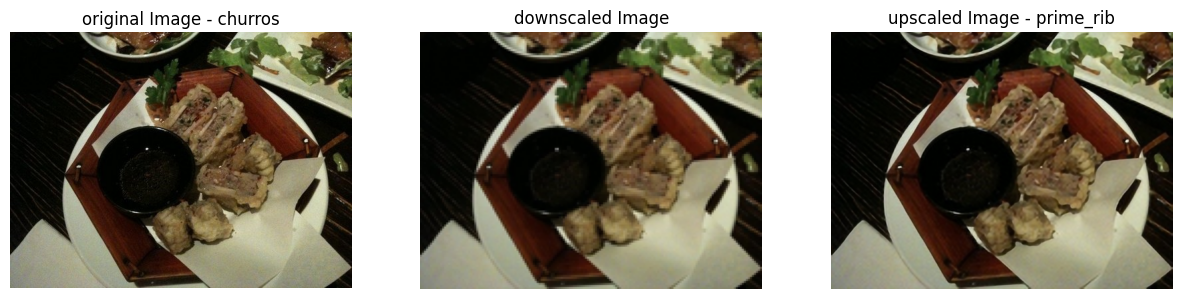

True label of image below is grilled_salmon


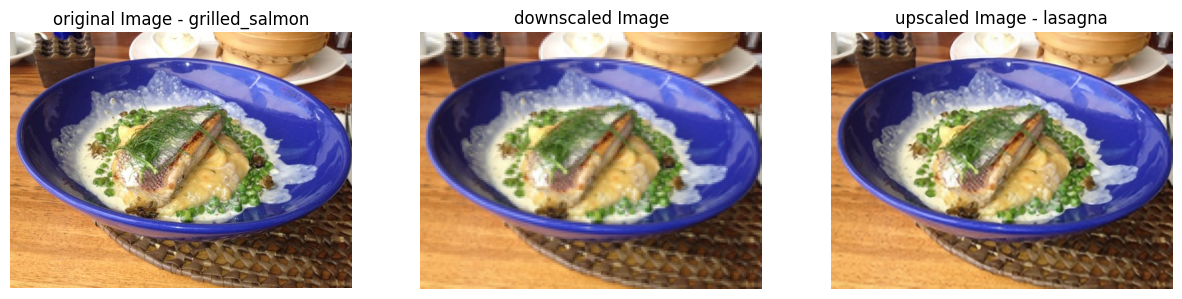

True label of image below is ice_cream


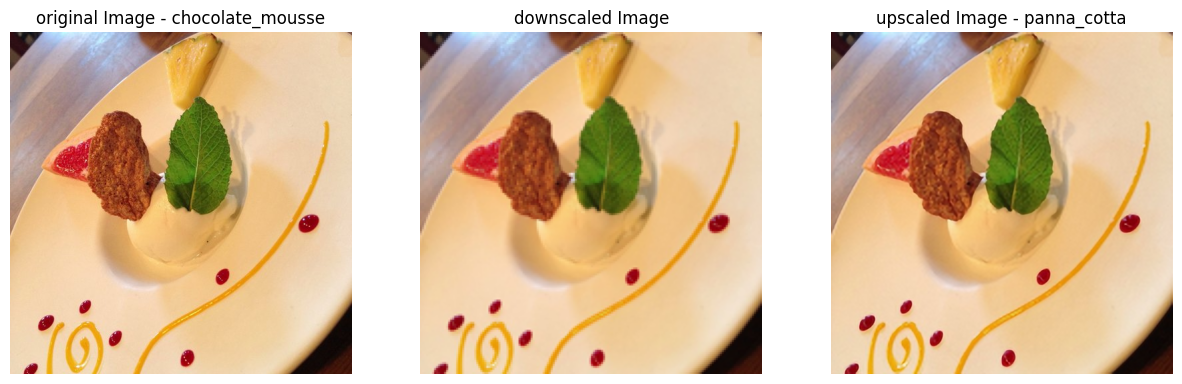

True label of image below is panna_cotta


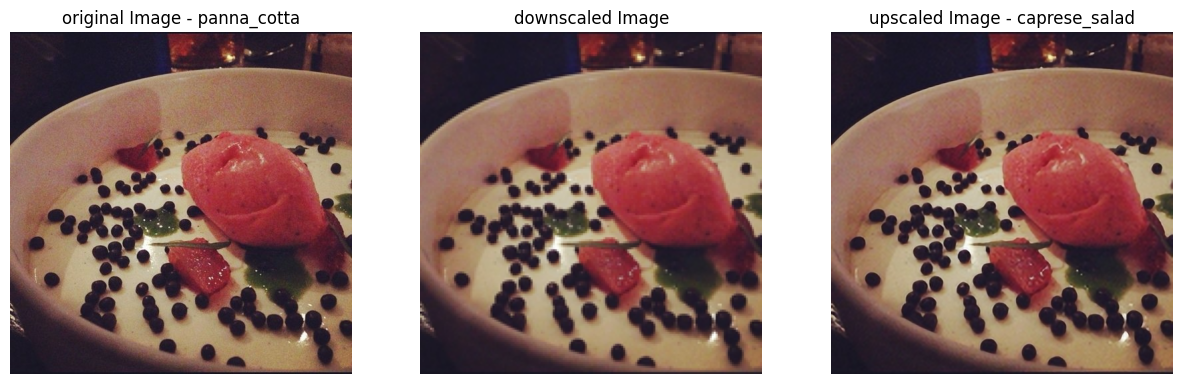

In [ ]:
differences = [index for index, (x, y) in enumerate(zip(predicted_labels_og, predicted_labels_up)) if x != y]
differences = [index for index in differences if index is not None]

for index in differences:
  compare_images(index)

## Run with new weights after further training

In [ ]:
true_labels = []
predicted_labels_up_new = []

for image, label in zip(dataset_sample["image"], dataset_sample["label"]):
    image_array = np.array(image)

    # Transform image to .bmp format
    img = Image.fromarray(image_array)
    img.save("image.bmp", format="BMP")

    # Run upscaling model on the image
    subprocess.run(['python', 'test.py', '--weights-file', 'epoch_4(BEST).pth', '--image-file', 'image.bmp', '--scale', '3'])

    # Convert the loaded upscaled image to JpegImageFile format
    image = Image.open("image_srcnn_x3.bmp")
    image = image.convert("RGB")

    # Run the classification model on the new upscaled image
    inputs = processor(image, return_tensors="pt")

    with torch.no_grad():
        logits = model(**inputs).logits

    predicted_label = logits.argmax(-1).item()

    true_labels.append(label)
    predicted_labels_up_new.append(predicted_label)

In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels_up_new)
print(f"Accuracy: {accuracy * 100:.2f}%")

conf_matrix = confusion_matrix(true_labels, predicted_labels_up_new)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 88.00%
Confusion Matrix:
[[3 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]


True label of image below is gyoza


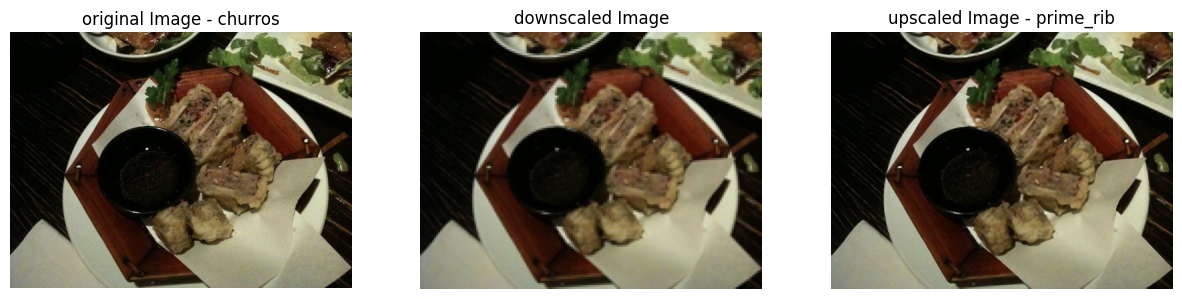

True label of image below is grilled_salmon


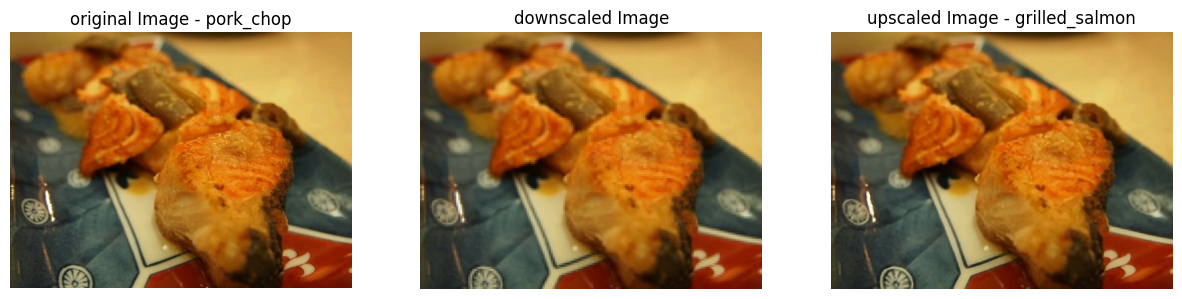

True label of image below is ice_cream


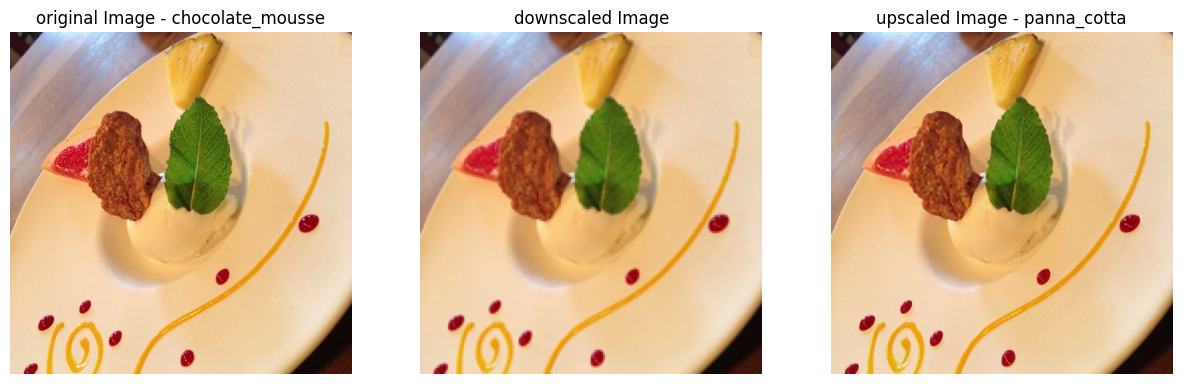

True label of image below is panna_cotta


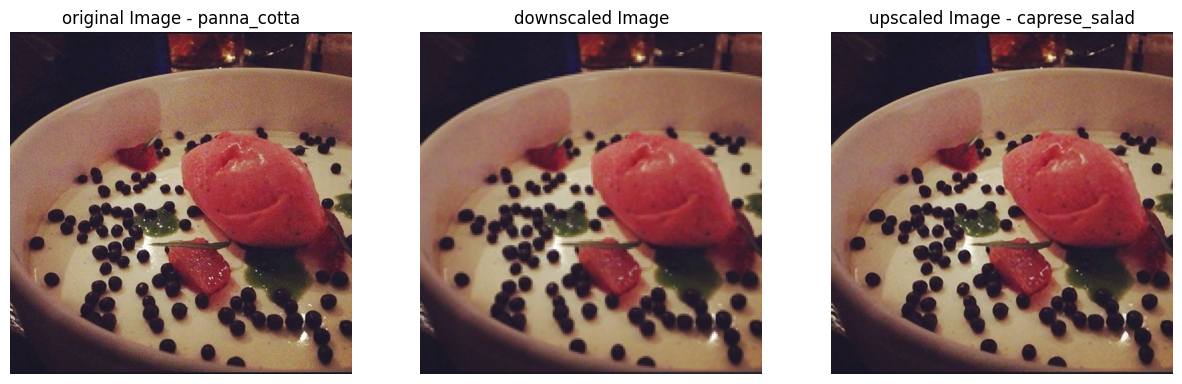

In [ ]:
differences = [index for index, (x, y) in enumerate(zip(predicted_labels_og, predicted_labels_up_new)) if x != y]
differences = [index for index in differences if index is not None]

for index in differences:
  compare_images(index)